# Momentum trading 

soruce: https://youtu.be/fqltiq5EahU?si=odnrErgXJ55Yirqd

In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "BTC/USD" # MDRX is shortable 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Cryptocurrency(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime(2024, 5, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-01-01 06:00:00+00:00,BTC/USD,29255.71,29682.29,28707.56,29676.79,848.874030,29639.0,29316.444625
2021-01-02 06:00:00+00:00,BTC/USD,29678.34,34200.00,29555.99,33769.52,2144.592516,60152.0,31941.412694
2021-01-03 06:00:00+00:00,BTC/USD,33769.52,34812.93,32300.61,32908.02,1838.695433,58725.0,33505.269474
2021-01-04 06:00:00+00:00,BTC/USD,32907.36,33496.03,27900.00,30441.57,2711.189503,69226.0,31267.965121
2021-01-05 06:00:00+00:00,BTC/USD,30461.84,35851.42,29927.55,35063.00,1756.751333,61880.0,33151.367357


In [2]:
data["day"] = np.arange(1, len(data)+1)
data.drop(columns=["volume", "trade_count", "vwap", "symbol"], inplace=True)
data = data[["day","high", "low", "open", "close"]]
data.head()

,day,high,low,open,close
timestamp,,,,,
2021-01-01 06:00:00+00:00,1,29682.29,28707.56,29255.71,29676.79
2021-01-02 06:00:00+00:00,2,34200.00,29555.99,29678.34,33769.52
2021-01-03 06:00:00+00:00,3,34812.93,32300.61,33769.52,32908.02
2021-01-04 06:00:00+00:00,4,33496.03,27900.00,32907.36,30441.57
2021-01-05 06:00:00+00:00,5,35851.42,29927.55,30461.84,35063.00


<Axes: xlabel='timestamp'>

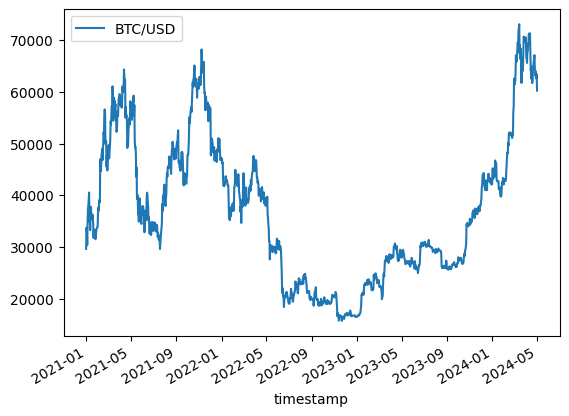

In [3]:
data.plot.line(y="close", use_index=True, label=SYMBOL)

In [4]:
#assert stk.is_sortable(), "To do momentum we want a to be able to short"

## moving avg

<Axes: xlabel='timestamp'>

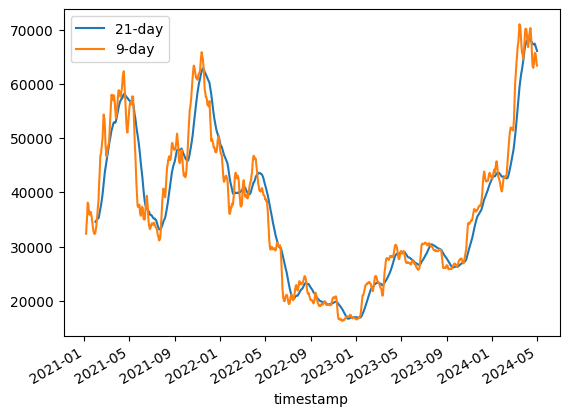

In [5]:
data["9-day"] = data["close"].rolling(5).mean().shift()
data["21-day"] = data["close"].rolling(30).mean().shift()
data[["21-day", "9-day"]].plot()

In [6]:
# add signal 
data["signal"] = np.where(data["9-day"] > data["21-day"], 1, 0) # long 
data["signal"] = np.where(data["9-day"] < data["21-day"], -1, data["signal"]) # short
data.dropna(inplace=True)
data.head()

,day,high,low,open,close,9-day,21-day,signal
timestamp,,,,,,,,
2021-01-31 06:00:00+00:00,31,34219.10,32200.00,33773.39,33787.13,32730.156,34564.908000,-1
2021-02-01 06:00:00+00:00,32,34707.60,33136.11,33787.67,34009.33,33177.972,34701.919333,-1
2021-02-02 06:00:00+00:00,33,36916.24,33954.16,34027.73,36510.08,33624.108,34709.913000,-1
2021-02-03 06:00:00+00:00,34,38431.27,35561.35,36506.68,37646.60,34317.030,34829.981667,-1
2021-02-04 06:00:00+00:00,35,38747.61,36182.22,37634.49,37108.52,35142.914,35070.149333,1


In [7]:
data["signal"]

timestamp
2021-01-31 06:00:00+00:00   -1
2021-02-01 06:00:00+00:00   -1
2021-02-02 06:00:00+00:00   -1
2021-02-03 06:00:00+00:00   -1
2021-02-04 06:00:00+00:00    1
                            ..
2024-04-26 05:00:00+00:00   -1
2024-04-27 05:00:00+00:00   -1
2024-04-28 05:00:00+00:00   -1
2024-04-29 05:00:00+00:00   -1
2024-04-30 05:00:00+00:00   -1
Name: signal, Length: 1186, dtype: int64

In [8]:
data['return'] = np.log(data['close']).diff()
data['system_return'] = data['signal'] * data['return']
data['entry'] = data.signal.diff()
data.head()

,day,high,low,open,close,9-day,21-day,signal,return,system_return,entry
timestamp,,,,,,,,,,,
2021-01-31 06:00:00+00:00,31,34219.10,32200.00,33773.39,33787.13,32730.156,34564.908000,-1,NaN,NaN,NaN
2021-02-01 06:00:00+00:00,32,34707.60,33136.11,33787.67,34009.33,33177.972,34701.919333,-1,0.006555,-0.006555,0.0
2021-02-02 06:00:00+00:00,33,36916.24,33954.16,34027.73,36510.08,33624.108,34709.913000,-1,0.070953,-0.070953,0.0
2021-02-03 06:00:00+00:00,34,38431.27,35561.35,36506.68,37646.60,34317.030,34829.981667,-1,0.030654,-0.030654,0.0
2021-02-04 06:00:00+00:00,35,38747.61,36182.22,37634.49,37108.52,35142.914,35070.149333,1,-0.014396,-0.014396,2.0


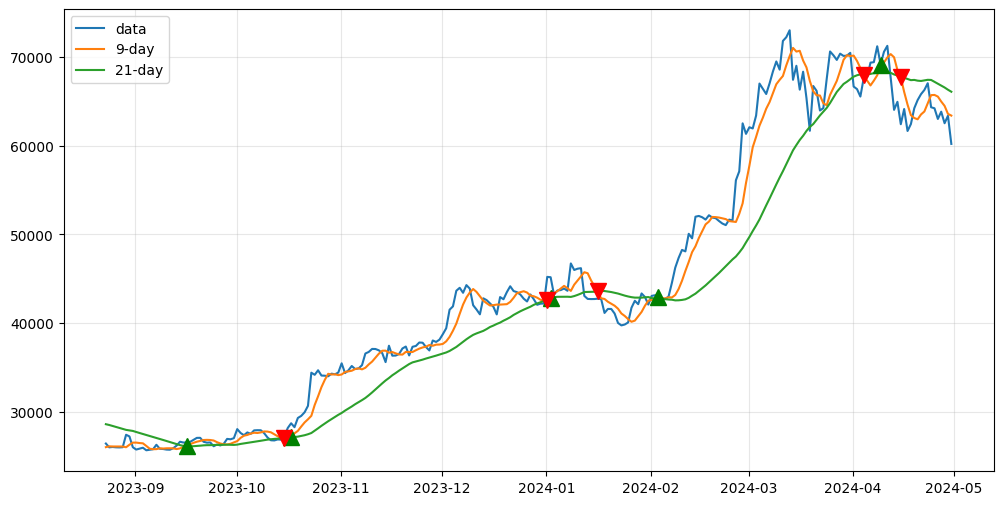

In [9]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(data.iloc[-252:]['close'], label = 'data')
plt.plot(data.iloc[-252:]['9-day'], label = '9-day')
plt.plot(data.iloc[-252:]['21-day'], label = '21-day')
plt.plot(data[-252:].loc[data.entry == 2].index, data[-252:]['9-day'][data.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(data[-252:].loc[data.entry == -2].index, data[-252:]['21-day'][data.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

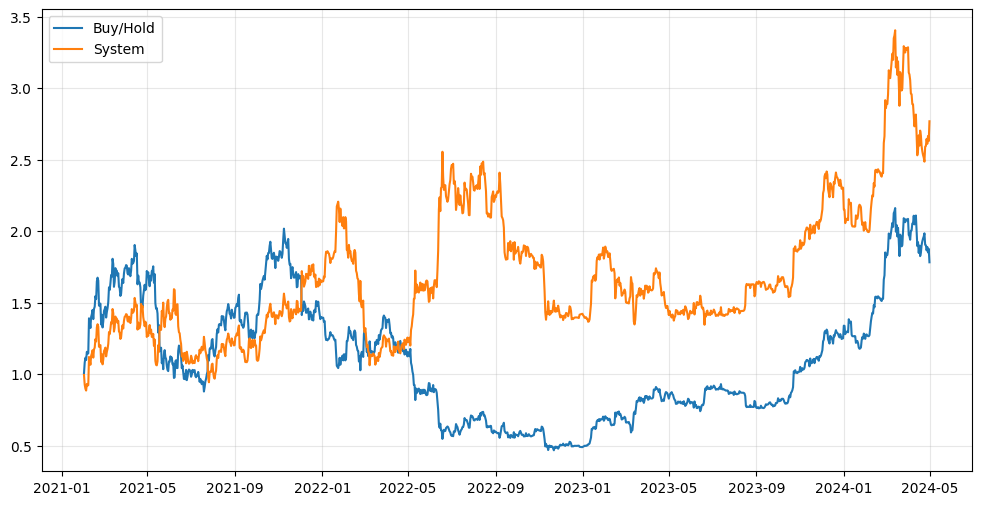

In [10]:
plt.plot(np.exp(data['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(data['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

# making it a cira strategy 

In [11]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "BTC/USD" # MDRX is shortable 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime(2024, 5, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-01-01 06:00:00+00:00,BTC/USD,29255.71,29682.29,28707.56,29676.79,848.874030,29639.0,29316.444625
2021-01-02 06:00:00+00:00,BTC/USD,29678.34,34200.00,29555.99,33769.52,2144.592516,60152.0,31941.412694
2021-01-03 06:00:00+00:00,BTC/USD,33769.52,34812.93,32300.61,32908.02,1838.695433,58725.0,33505.269474
2021-01-04 06:00:00+00:00,BTC/USD,32907.36,33496.03,27900.00,30441.57,2711.189503,69226.0,31267.965121
2021-01-05 06:00:00+00:00,BTC/USD,30461.84,35851.42,29927.55,35063.00,1756.751333,61880.0,33151.367357


In [12]:
data["day"] = np.arange(1, len(data)+1)
data.drop(columns=["volume", "trade_count", "vwap", "symbol"], inplace=True)
data = data[["day","high", "low", "open", "close"]]
data.head()

,day,high,low,open,close
timestamp,,,,,
2021-01-01 06:00:00+00:00,1,29682.29,28707.56,29255.71,29676.79
2021-01-02 06:00:00+00:00,2,34200.00,29555.99,29678.34,33769.52
2021-01-03 06:00:00+00:00,3,34812.93,32300.61,33769.52,32908.02
2021-01-04 06:00:00+00:00,4,33496.03,27900.00,32907.36,30441.57
2021-01-05 06:00:00+00:00,5,35851.42,29927.55,30461.84,35063.00


<Axes: xlabel='timestamp'>

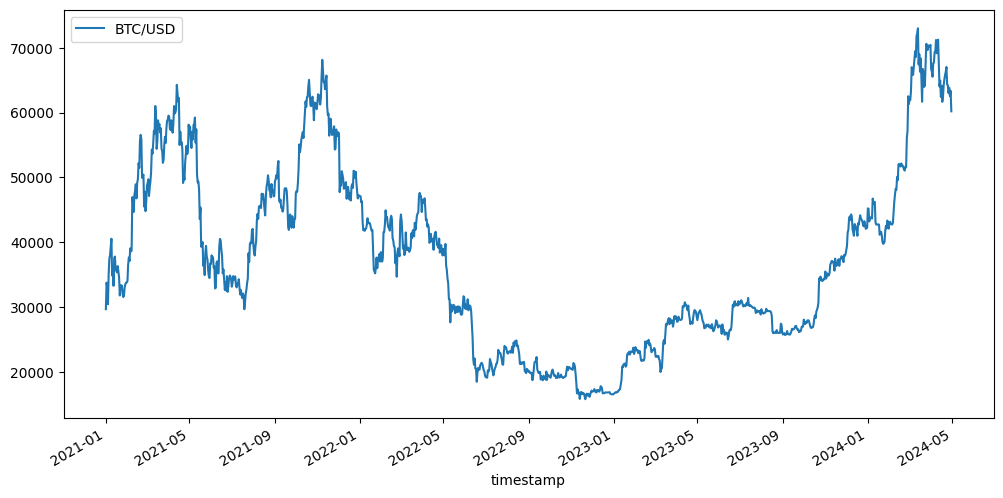

In [13]:
data.plot.line(y="close", use_index=True, label=SYMBOL)

In [37]:
from cira.strategy import Strategy
from numpy import ndarray
from pandas import DataFrame

class Momentum(Strategy):
    def __init__(self, fast_moving = 9, slow_moving=21, risk=0.02) -> None:
        super().__init__(name = "Momentum")
        self.fast_moving = fast_moving
        self.slow_moving = slow_moving
        self.risk = risk
        self.sizeings = {"position_size":[]}

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash=float) -> ndarray: 
        data = prices.copy()
        data["fast-avg"] = data["close"].rolling(self.fast_moving).mean().shift()
        data["slow-avg"] = data["close"].rolling(self.slow_moving).mean().shift()
        data["signal"] = np.where(data["fast-avg"] > data["slow-avg"], 1, 0) # long 
        data["signal"] = np.where(data["fast-avg"] < data["slow-avg"], -1, data["signal"]) # short but we will sell 
        data.dropna(inplace=True)
        data['return'] = np.log(data['close']).diff()
        data['system_return'] = data['signal'] * data['return']
        data['entry'] = data.signal.diff()
        new_pos = 0
        if len(data) == 0:
            pass 
        elif data["entry"].values[-1] == 2: # buy 
            new_pos = self.size(cash, portfolio[-1], prices.values.squeeze()[-1])
        elif data["entry"].values[-1] == -2: # sell 
            new_pos = -1 * self.size(cash, int(portfolio[-1]), prices.values.squeeze()[-1])
        self.sizeings["position_size"].append(new_pos)
        return np.array([new_pos])


    def size(self, cash, current_holding, entry_price) -> int: 
        return int((cash * (current_holding + 1 ) * self.risk ) / entry_price)



<Axes: xlabel='timestamp'>

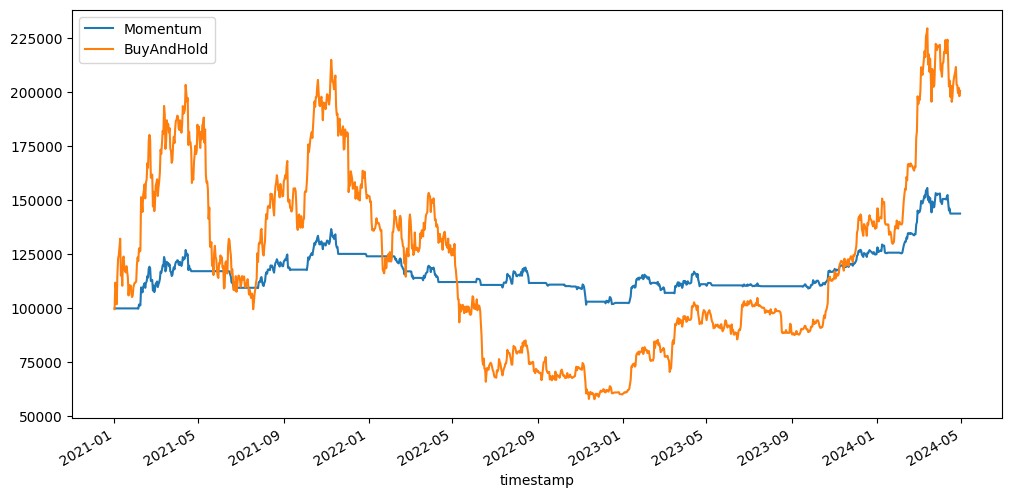

In [42]:
from cira.strategy import back_test_against_buy_and_hold as back_test

features = ['open', 'high', 'low', 'close']
target = "close"
strat = Momentum(fast_moving=5, slow_moving=30, risk=0.50)
prices_df = pd.DataFrame(data[target], columns=['close'])
back_test(strat, data[features], prices_df, 100_000).plot()

<Axes: >

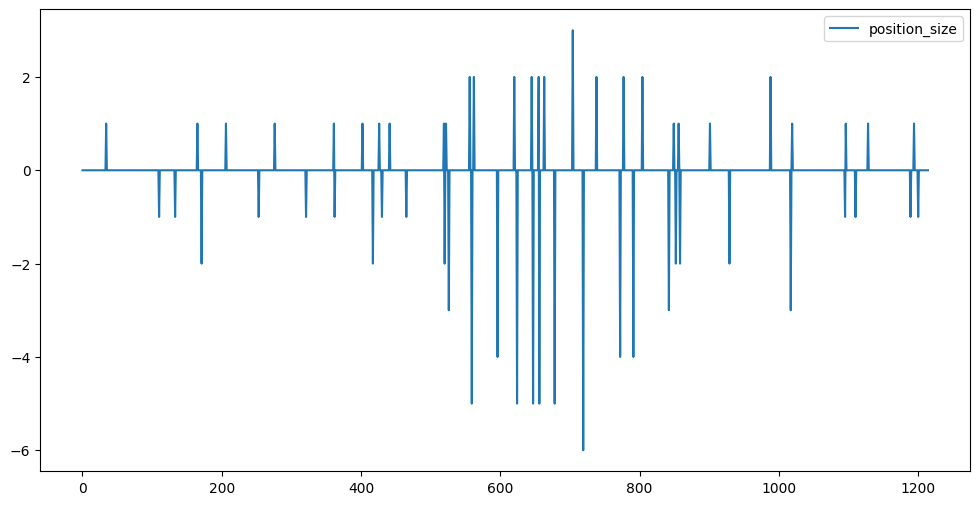

In [43]:
pd.DataFrame(strat.sizeings).plot()